In [5]:
#conda env create -f urban_env.yml
#conda activate urban


import geopandas
import libpysal
import matplotlib.pyplot as plt
import momepy
import osmnx
import pandas
from bokeh.io import output_notebook
from bokeh.plotting import show
from clustergram import Clustergram

output_notebook()

Loading BokehJS ...

In [6]:
place = "Znojmo, Czechia"
local_crs = 5514

In [7]:
geopandas.tools.geocode(place).explore()

In [8]:
buildings = osmnx.features_from_place(place, tags={"building": True})
buildings.head()

name tourism                   geometry  \
element_type osmid                                                           
node         3372076291    7/I/10/A-120     NaN  POINT (16.05376 48.84683)   
             3372076393  7/I/11/A-140 Z     NaN  POINT (16.05581 48.84158)   
             3372076394    7/I/12/A-220     NaN  POINT (16.05867 48.83522)   
             3372076428         7/I/8/E     NaN  POINT (16.03949 48.85599)   
             3372076429         7/I/9/E     NaN  POINT (16.04133 48.85501)   

                        man_made operator power amenity brand brand:wikidata  \
element_type osmid                                                             
node         3372076291      NaN      NaN   NaN     NaN   NaN            NaN   
             3372076393      NaN      NaN   NaN     NaN   NaN            NaN   
             3372076394      NaN      NaN   NaN     NaN   NaN            NaN   
             3372076428      NaN      NaN   NaN     NaN   NaN            NaN   
             3372076429      NaN      NaN   NaN     NaN   NaN            NaN   

                        brand:wikipedia  ... ref:koda branch  \
element_type osmid                       ...                   
node         3372076291             NaN  ...      NaN    NaN   
             3372076393             NaN  ...      NaN    NaN   
             3372076394             NaN  ...      NaN    NaN   
             3372076428             NaN  ...      NaN    NaN   
             3372076429             NaN  ...      NaN    NaN   

                        monitoring:water_level automated self_service  \
element_type osmid                                                      
node         3372076291                    NaN       NaN          NaN   
             3372076393                    NaN       NaN          NaN   
             3372076394                    NaN       NaN          NaN   
             3372076428                    NaN       NaN          NaN   
             3372076429                    NaN       NaN          NaN   

                        shelter_type bridge:support construction ways type  
element_type osmid                                                          
node         3372076291          NaN            NaN          NaN  NaN  NaN  
             3372076393          NaN            NaN          NaN  NaN  NaN  
             3372076394          NaN            NaN          NaN  NaN  NaN  
             3372076428          NaN            NaN          NaN  NaN  NaN  
             3372076429          NaN            NaN          NaN  NaN  NaN  

[5 rows x 135 columns]

In [9]:
buildings.geom_type.value_counts()

Polygon    12313
Point          8
Name: count, dtype: int64

In [10]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

In [11]:
buildings = buildings[["geometry"]].to_crs(local_crs)
buildings.head()

,geometry
0,"POLYGON ((-643743.474 -1193358.749, -643743.30..."
1,"POLYGON ((-643751.401 -1193530.694, -643749.37..."
2,"POLYGON ((-643281.601 -1193130.831, -643283.76..."
3,"POLYGON ((-643381.904 -1193174.697, -643388.48..."
4,"POLYGON ((-643370.450 -1193130.215, -643398.26..."


In [12]:
osm_graph = osmnx.graph_from_place(place, network_type="drive")
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)
streets = osmnx.graph_to_gdfs(
    osmnx.convert.to_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
).reset_index(drop=True)
streets.head()

,osmid,ref,name,highway,maxspeed,oneway,reversed,length,from,to,geometry,lanes,bridge,width,junction,tunnel,access
0,33733060,361,Přímětická,secondary,50,False,True,24.574,639231391,74103628,"LINESTRING (-643229.639 -1192872.949, -643239....",NaN,NaN,NaN,NaN,NaN,NaN
1,33733060,361,Přímětická,secondary,50,False,False,60.347,3775990798,74103628,"LINESTRING (-643236.395 -1192790.304, -643236....",NaN,NaN,NaN,NaN,NaN,NaN
2,50313252,NaN,Raisova,residential,NaN,True,False,74.763,639231413,74103628,"LINESTRING (-643291.344 -1192797.012, -643288....",NaN,NaN,NaN,NaN,NaN,NaN
3,33733060,361,Přímětická,secondary,50,False,True,54.260,74142638,639231391,"LINESTRING (-643205.434 -1192921.533, -643219....",NaN,NaN,NaN,NaN,NaN,NaN
4,50313241,NaN,Mičurinova,residential,NaN,True,False,101.376,639231391,639231314,"LINESTRING (-643229.639 -1192872.949, -643233....",NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]

In [14]:
streets.head()

,geometry
0,"LINESTRING (-643229.639 -1192872.949, -643239...."
1,"LINESTRING (-643236.395 -1192790.304, -643236...."
2,"LINESTRING (-643291.344 -1192797.012, -643288...."
3,"LINESTRING (-643205.434 -1192921.533, -643219...."
4,"LINESTRING (-643229.639 -1192872.949, -643233...."


In [15]:
limit = momepy.buffered_limit(buildings, "adaptive")

tessellation = momepy.morphological_tessellation(buildings, clip=limit)

c:\Users\Andrea\miniconda3\envs\urban\lib\site-packages\libpysal\graph\base.py:1375: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  head, tail, weights = _gabriel(


In [16]:
collapsed, _ = momepy.verify_tessellation(tessellation, buildings)

C:\Users\Andrea\AppData\Local\Temp\ipykernel_17676\3509021287.py:1: UserWarning: Tessellation does not fully match buildings. 21 element(s) disappeared during generation. Index of the affected elements: Index([ 3929,  3939,  4148,  4156,  4159,  4186,  4189,  4193,  4194,  4198,
        8485,  8712,  8966,  9001, 10400, 10618, 10619, 11187, 11404, 11405,
       11409],
      dtype='int64').
  collapsed, _ = momepy.verify_tessellation(tessellation, buildings)
C:\Users\Andrea\AppData\Local\Temp\ipykernel_17676\3509021287.py:1: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. Index of affected elements: [1, 209, 520, 523, 524, 634, 707, 760, 785, 1338, 1621, 1626, 1627, 1631, 1633, 1639, 1648, 1683, 1692, 2318, 2862, 2893, 2908, 3148, 3754, 4143, 4638, 4650, 4696, 4903, 5148, 5279, 5454, 5660, 5759, 6105, 6332, 6339, 6344, 6375, 6520, 6546, 6603, 6928, 7128, 7141, 7189, 7333, 7334, 7335, 7336, 7337, 7339, 7340, 7341, 7342, 7344, 7346, 7347, 7350

In [17]:
buildings = buildings.drop(collapsed)
limit = momepy.buffered_limit(buildings, "adaptive")
tessellation = momepy.morphological_tessellation(buildings, clip=limit)

c:\Users\Andrea\miniconda3\envs\urban\lib\site-packages\libpysal\graph\base.py:1375: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  head, tail, weights = _gabriel(


In [18]:
tessellation.shape[0] == buildings.shape[0]

True

In [19]:
buildings["street_index"] = momepy.get_nearest_street(
    buildings, streets, max_distance=100
)
buildings

,geometry,street_index
0,"POLYGON ((-643743.474 -1193358.749, -643743.30...",977.0
1,"POLYGON ((-643751.401 -1193530.694, -643749.37...",NaN
2,"POLYGON ((-643281.601 -1193130.831, -643283.76...",184.0
3,"POLYGON ((-643381.904 -1193174.697, -643388.48...",596.0
4,"POLYGON ((-643370.450 -1193130.215, -643398.26...",596.0
...,...,...
12308,"POLYGON ((-642784.166 -1193282.597, -642782.58...",109.0
12309,"POLYGON ((-641909.939 -1196185.823, -641920.49...",237.0
12310,"POLYGON ((-641157.498 -1193763.763, -641173.34...",1005.0
12311,"POLYGON ((-645060.824 -1196234.041, -645050.36...",NaN


Link Street

In [21]:
buildings["street_index"] = momepy.get_nearest_street(
    buildings, streets, max_distance=100
)
buildings

,geometry,street_index
0,"POLYGON ((-643743.474 -1193358.749, -643743.30...",977.0
1,"POLYGON ((-643751.401 -1193530.694, -643749.37...",NaN
2,"POLYGON ((-643281.601 -1193130.831, -643283.76...",184.0
3,"POLYGON ((-643381.904 -1193174.697, -643388.48...",596.0
4,"POLYGON ((-643370.450 -1193130.215, -643398.26...",596.0
...,...,...
12308,"POLYGON ((-642784.166 -1193282.597, -642782.58...",109.0
12309,"POLYGON ((-641909.939 -1196185.823, -641920.49...",237.0
12310,"POLYGON ((-641157.498 -1193763.763, -641173.34...",1005.0
12311,"POLYGON ((-645060.824 -1196234.041, -645050.36...",NaN


In [22]:
tessellation["street_index"] = buildings["street_index"]

## Measure

Dimension

In [23]:
buildings["building_area"] = buildings.area
tessellation["tess_area"] = tessellation.area
streets["length"] = streets.length

Shape

In [24]:
buildings["eri"] = momepy.equivalent_rectangular_index(buildings)
buildings["elongation"] = momepy.elongation(buildings)
tessellation["convexity"] = momepy.convexity(tessellation)
streets["linearity"] = momepy.linearity(streets)

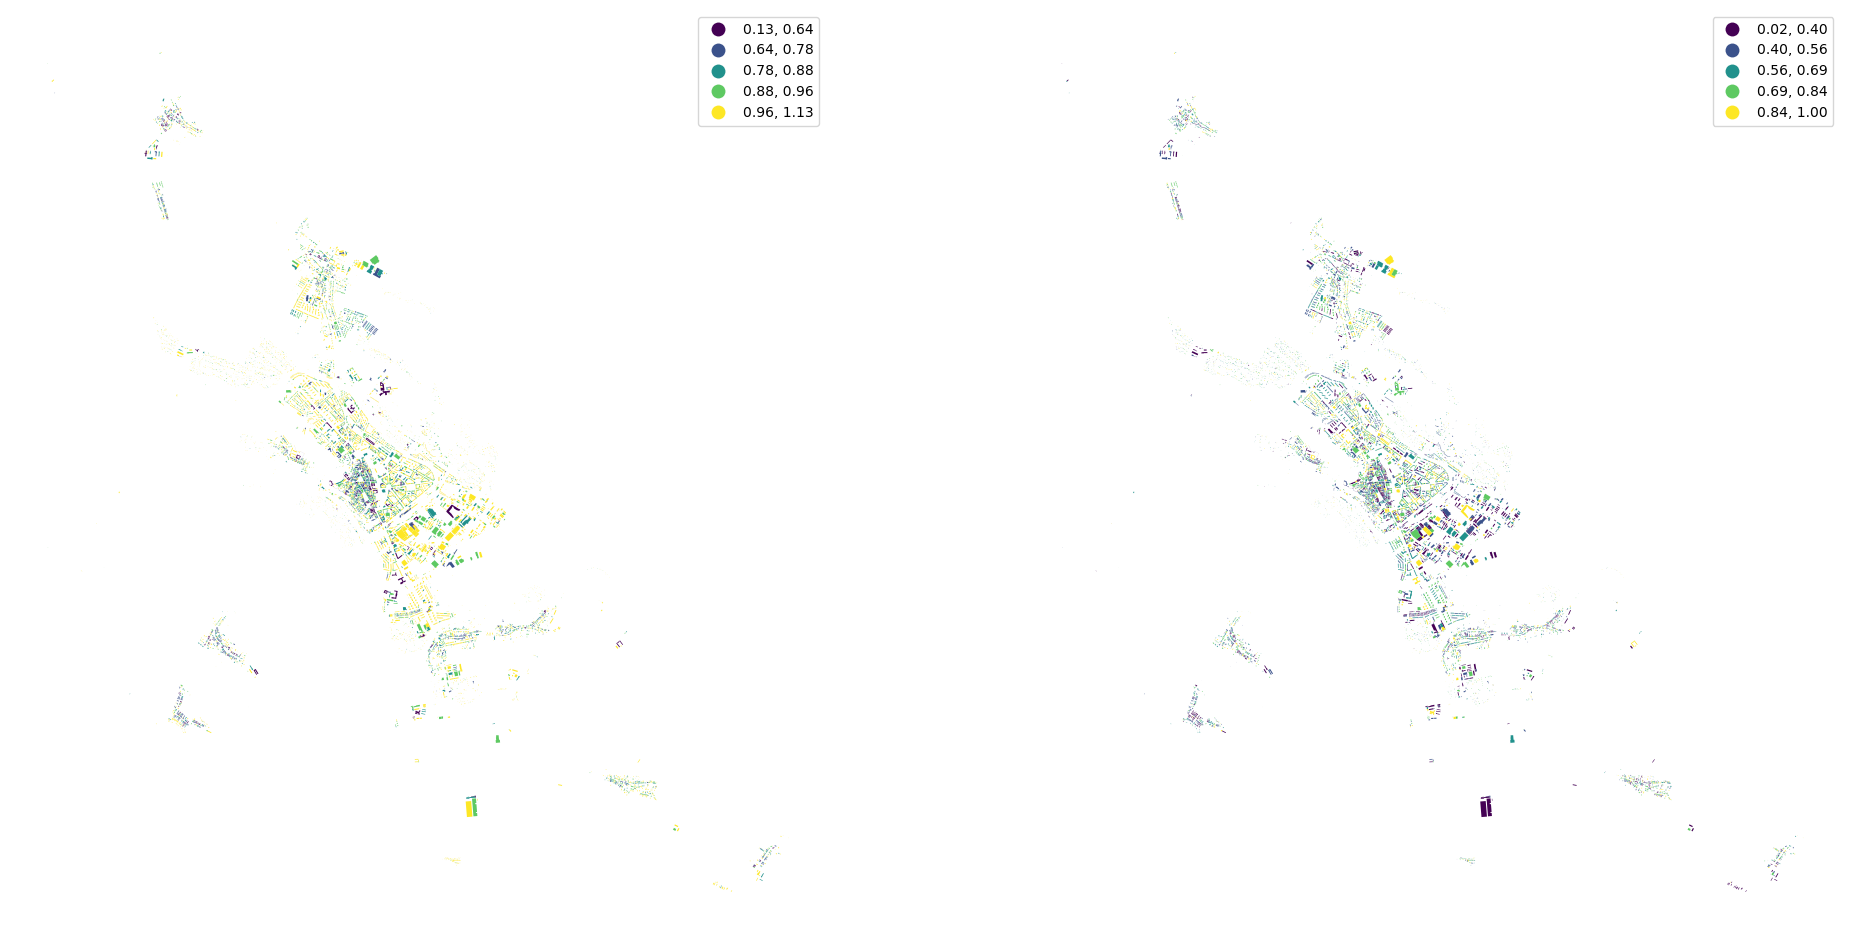

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

## Spatial Distribution

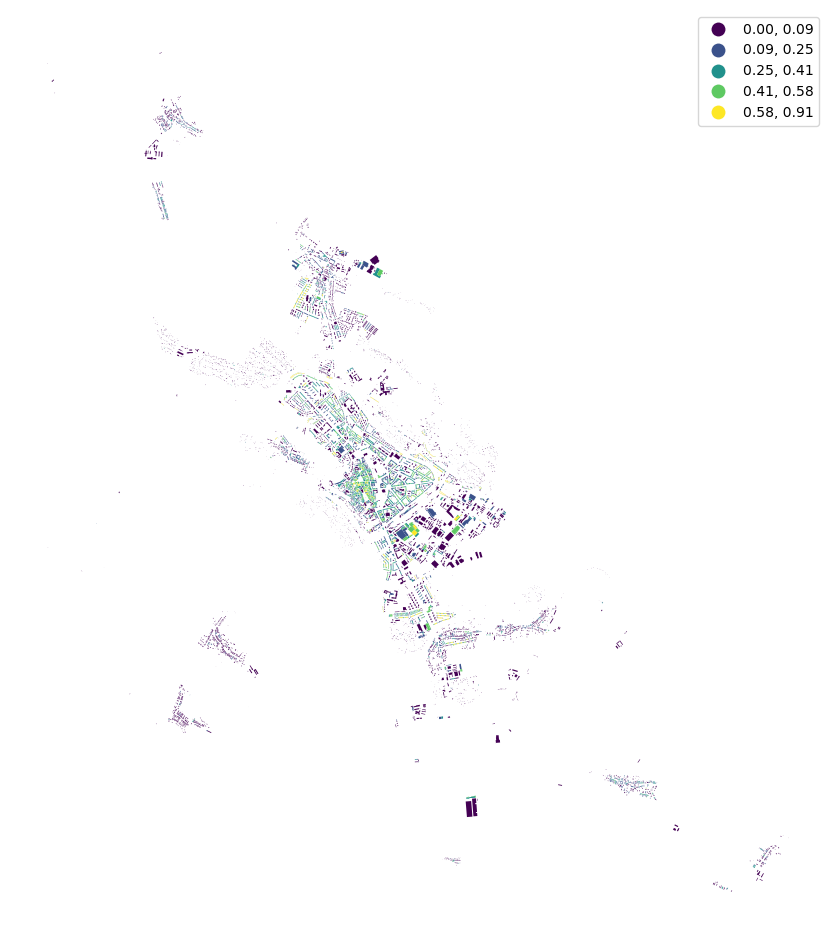

In [26]:
buildings["shared_walls"] = momepy.shared_walls(buildings) / buildings.length
buildings.plot(
    "shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True
).set_axis_off()

In [27]:
queen_1 = libpysal.graph.Graph.build_contiguity(tessellation, rook=False)

In [28]:
tessellation["neighbors"] = momepy.neighbors(
    tessellation, queen_1, weighted=True
)
tessellation["covered_area"] = queen_1.describe(tessellation.area)["sum"]
buildings["neighbor_distance"] = momepy.neighbor_distance(buildings, queen_1)

C:\Users\Andrea\AppData\Local\Temp\ipykernel_17676\2369634746.py:4: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  tessellation["covered_area"] = queen_1.describe(tessellation.area)["sum"]
c:\Users\Andrea\miniconda3\envs\urban\lib\site-packages\momepy\functional\_distribution.py:285: UserWarning: The indices of the two GeoSeries are different.
  (geoms.distance(geometry.geometry, align=True)).groupby(level=0).mean()


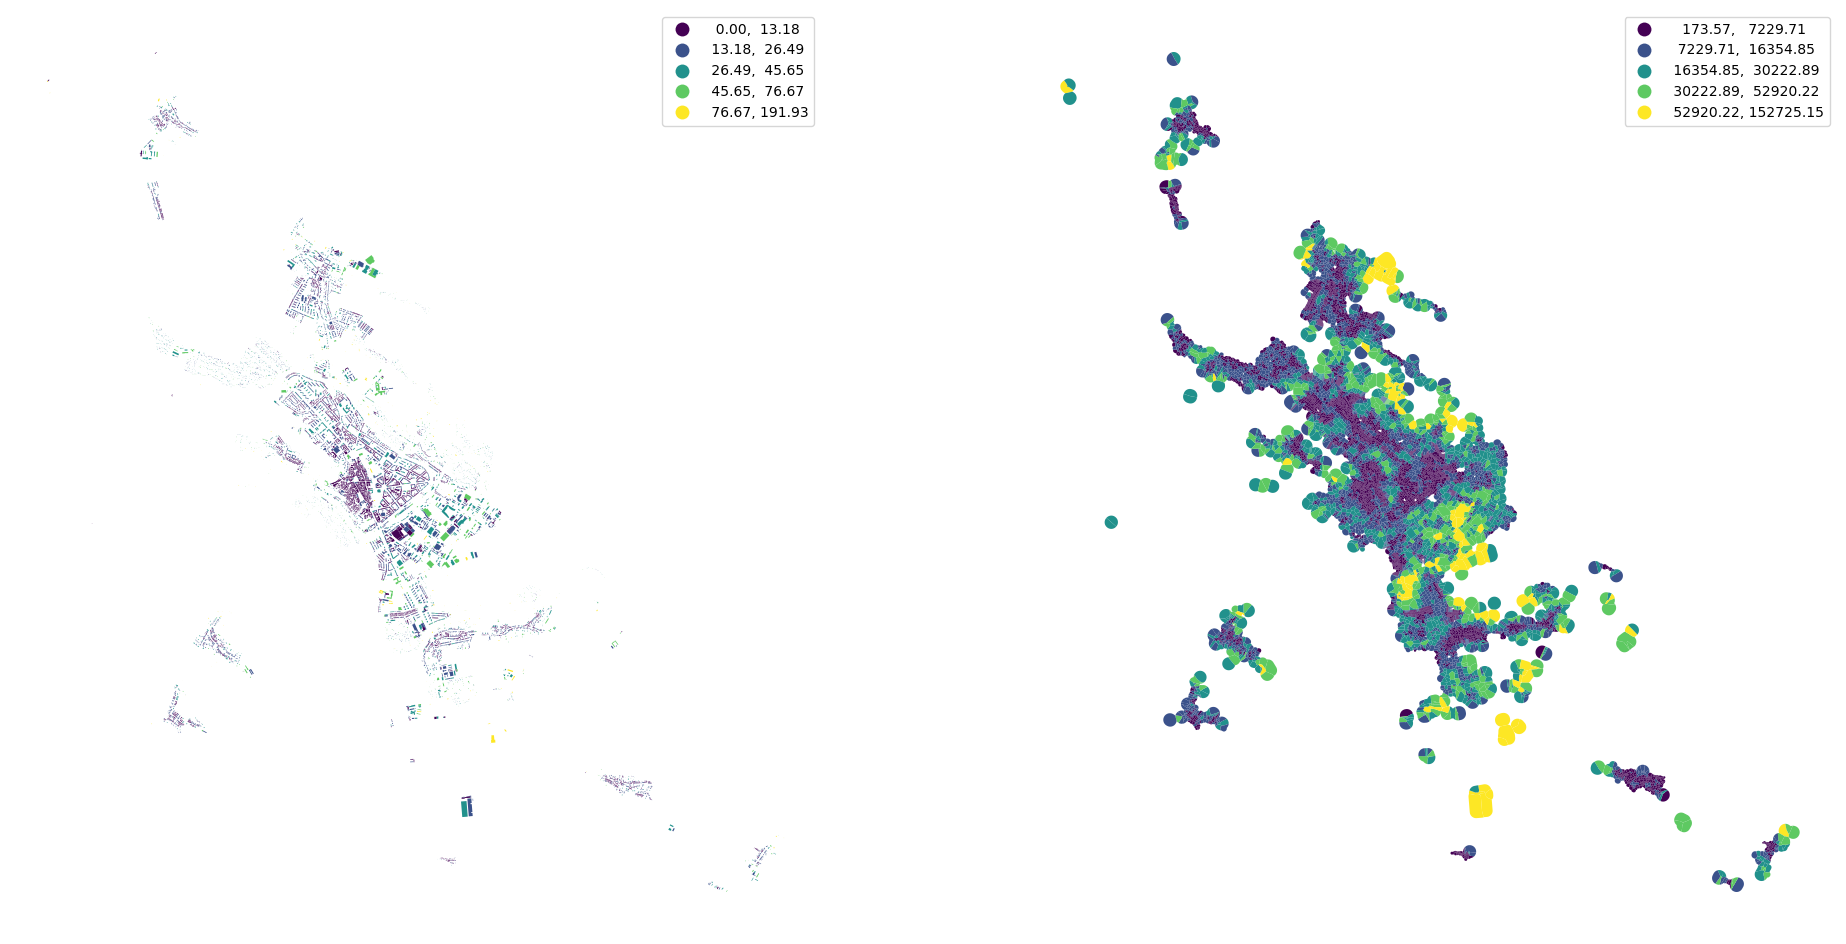

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot(
    "neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True
)
tessellation.plot(
    "covered_area", ax=ax[1], scheme="natural_breaks", legend=True
)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [30]:
queen_3 = queen_1.higher_order(3)
buildings_q1 = libpysal.graph.Graph.build_contiguity(buildings, rook=False)

buildings["interbuilding_distance"] = momepy.mean_interbuilding_distance(
    buildings, queen_1, queen_3
)
buildings["adjacency"] = momepy.building_adjacency(buildings_q1, queen_3)

c:\Users\Andrea\miniconda3\envs\urban\lib\site-packages\momepy\functional\_distribution.py:382: RuntimeWarning: invalid value encountered in scalar divide
  mean_distances[i] = sub_matrix.sum() / sub_matrix.nnz


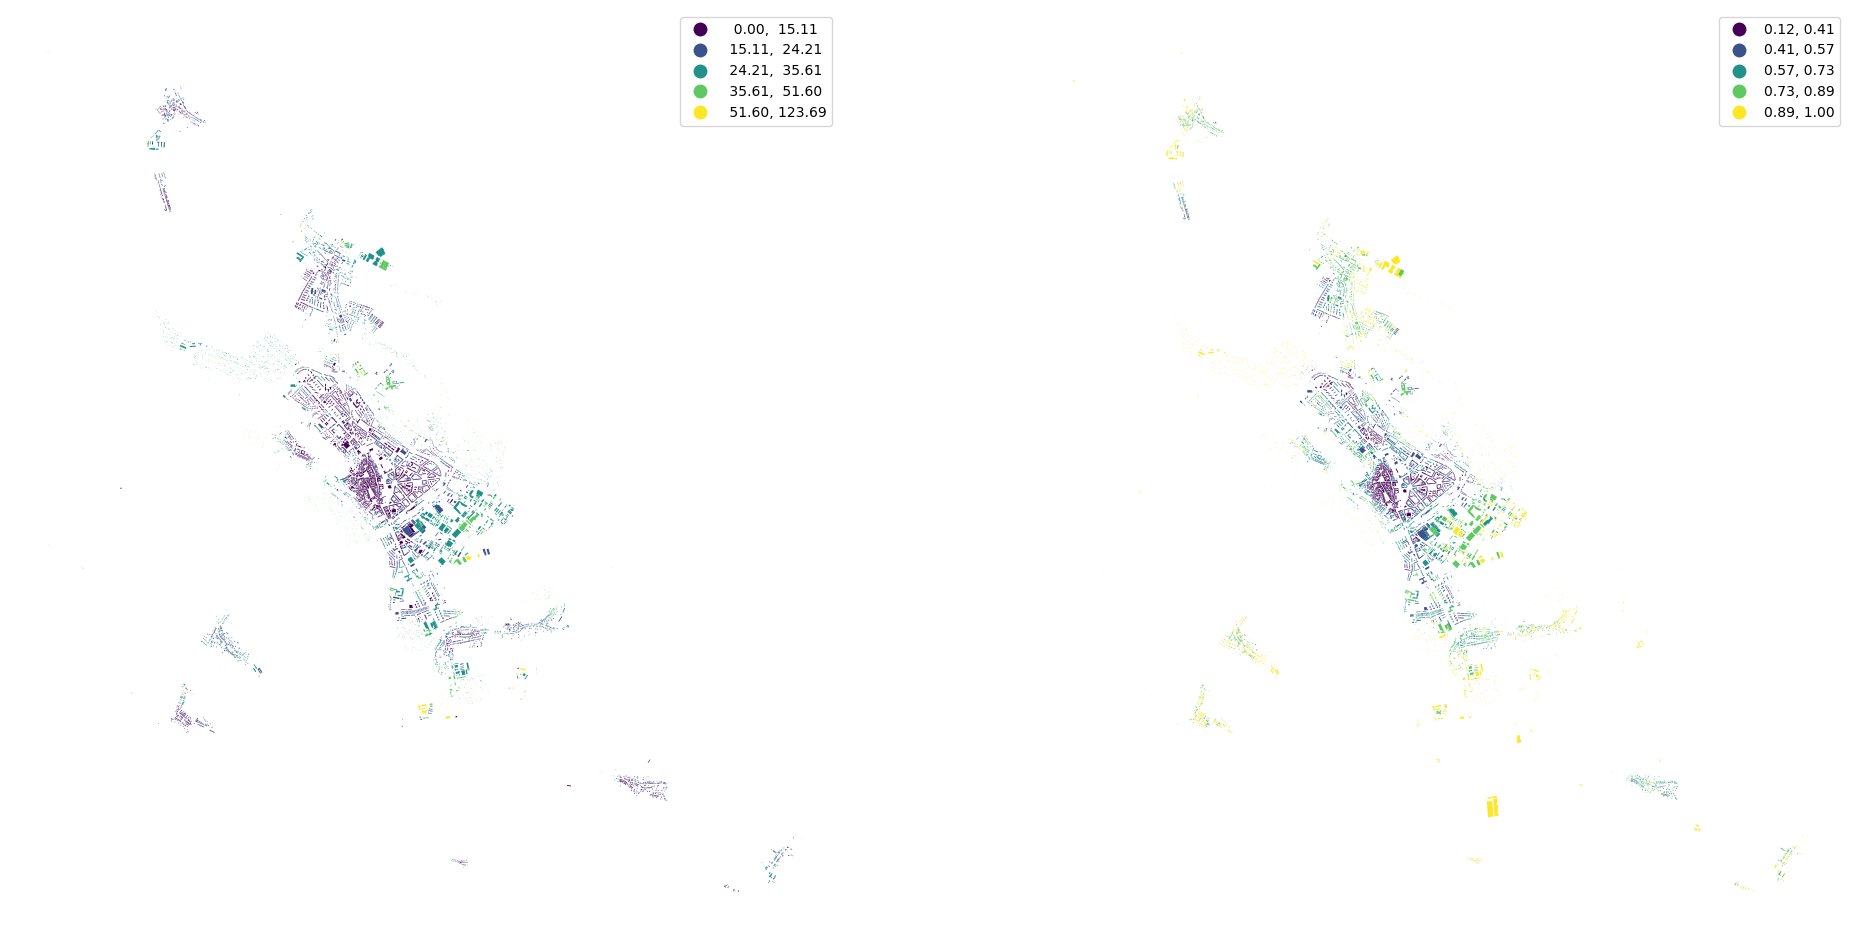

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot(
    "interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True
)
buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [32]:
profile = momepy.street_profile(streets, buildings)
streets[profile.columns] = profile

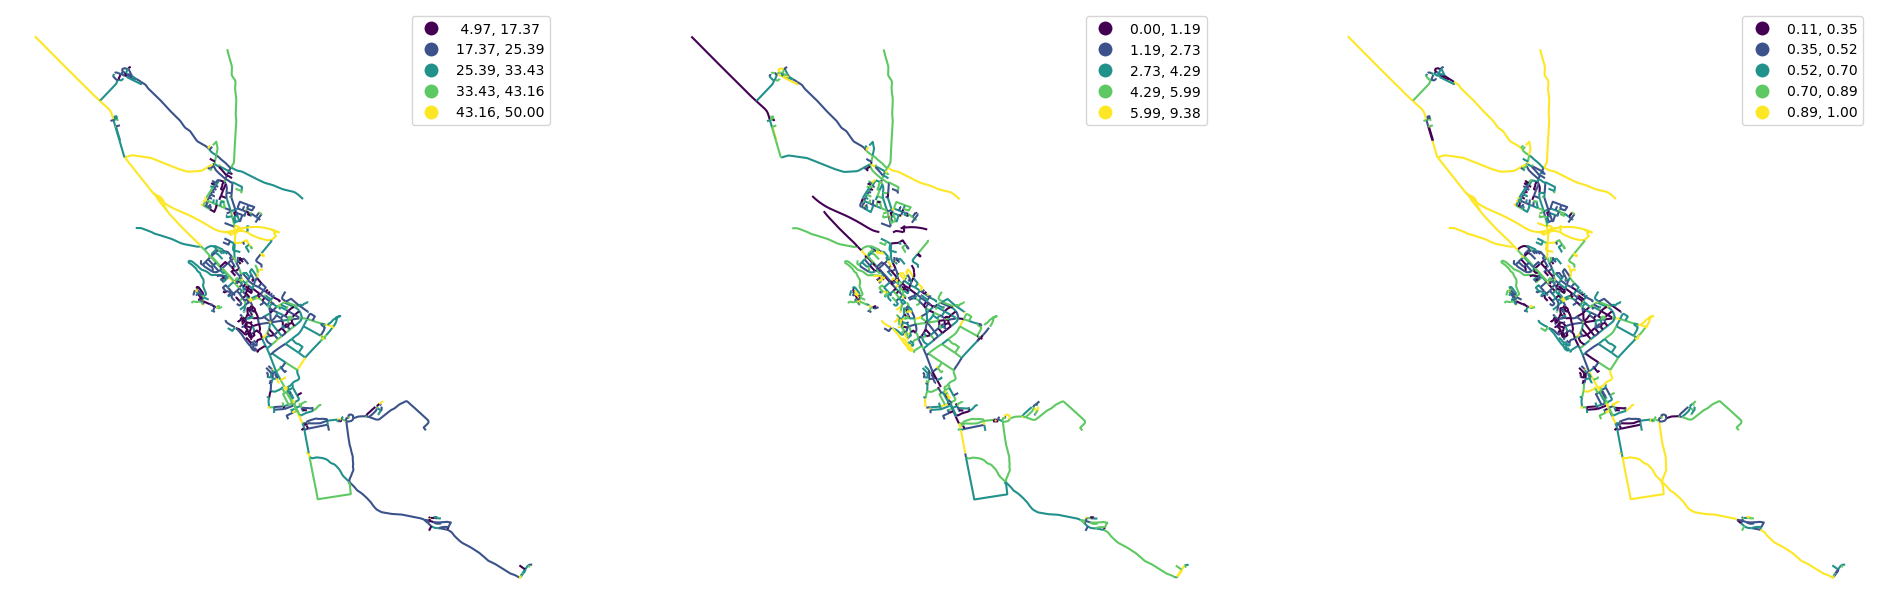

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

## Intensity

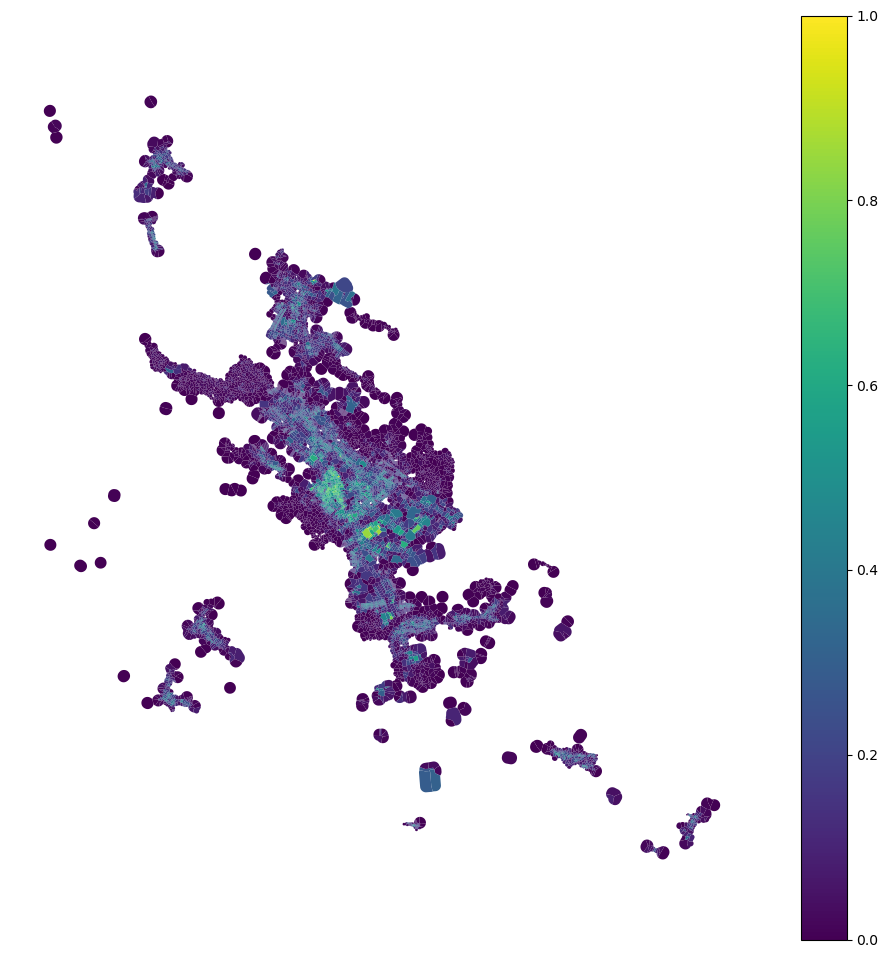

In [34]:
tessellation["car"] = buildings.area / tessellation.area
tessellation.plot(
    "car", figsize=(12, 12), vmin=0, vmax=1, legend=True
).set_axis_off()

## Connectivity

In [35]:
graph = momepy.gdf_to_nx(streets)
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")
nodes, edges = momepy.nx_to_gdf(graph)

100%|██████████| 779/779 [00:00<00:00, 824.27it/s]


c:\Users\Andrea\miniconda3\envs\urban\lib\site-packages\mapclassify\classifiers.py:687: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self._classify()


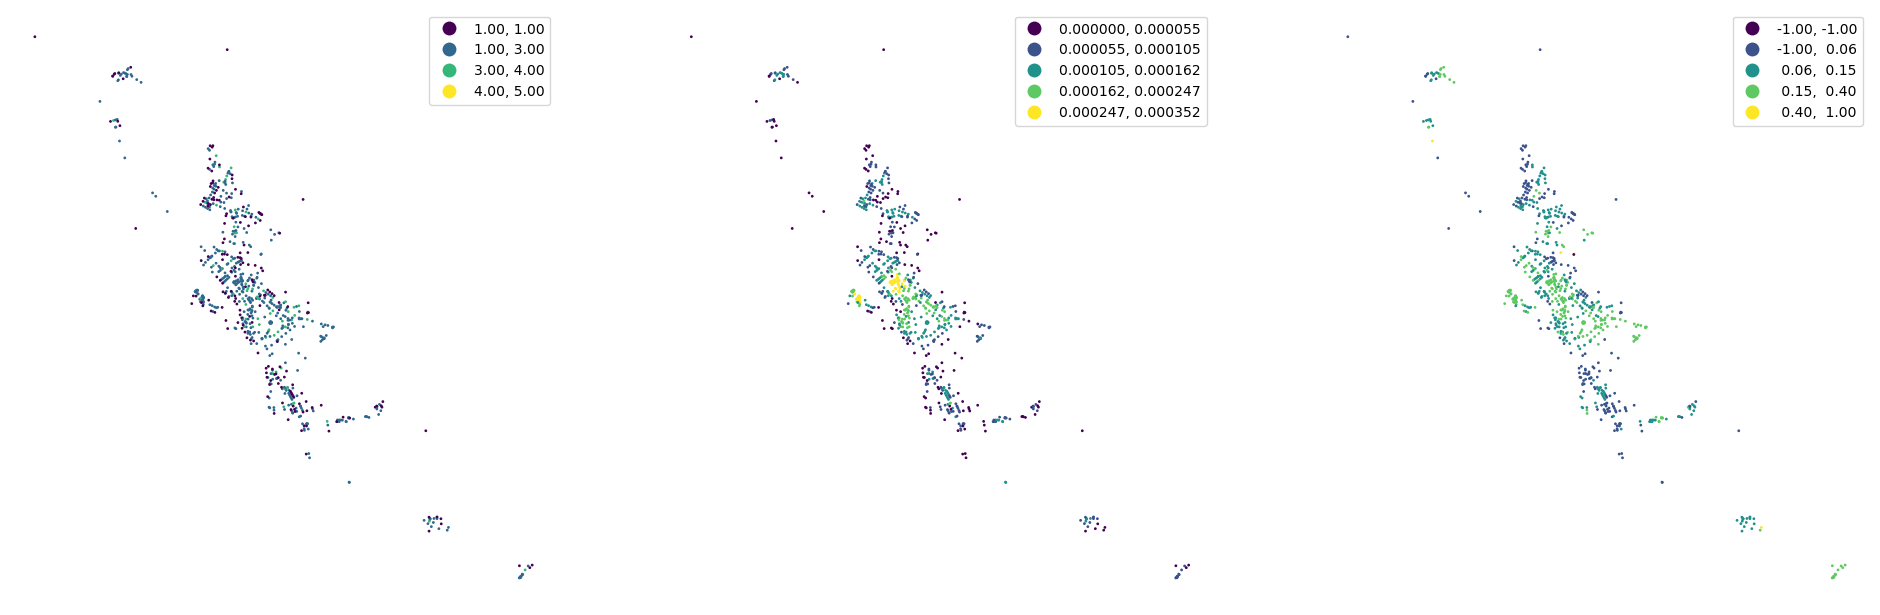

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot(
    "degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1
)
nodes.plot(
    "closeness",
    ax=ax[1],
    scheme="natural_breaks",
    legend=True,
    markersize=1,
    legend_kwds={"fmt": "{:.6f}"},
)
nodes.plot(
    "meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1
)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

In [37]:
buildings["edge_index"] = momepy.get_nearest_street(buildings, edges)
buildings["node_index"] = momepy.get_nearest_node(
    buildings, nodes, edges, buildings["edge_index"]
)

In [38]:
tessellation.head()

,geometry,street_index,tess_area,convexity,neighbors,covered_area,car
0,"POLYGON ((-643698.967 -1193400.726, -643699.69...",977.0,17802.172928,0.991874,0.007811,14723.914919,0.009702
1,"MULTIPOLYGON (((-643789.142 -1193533.074, -643...",NaN,10595.641409,0.904106,0.012668,45002.112108,0.002063
2,"POLYGON ((-643280.792 -1193133.236, -643280.82...",184.0,109.816852,0.993284,0.044640,12032.783443,0.744270
3,"POLYGON ((-643382.447 -1193179.713, -643382.97...",596.0,663.104922,0.891185,0.033418,17058.071382,0.387530
4,"POLYGON ((-643401.313 -1193134.830, -643400.96...",596.0,1750.723341,0.963757,0.052952,15224.521096,0.341471


In [39]:
buildings.head()

,geometry,street_index,building_area,eri,elongation,shared_walls,neighbor_distance,interbuilding_distance,adjacency,edge_index,node_index
0,"POLYGON ((-643743.474 -1193358.749, -643743.30...",977.0,172.724408,0.932464,0.842696,0.000000,56.674679,16.599365,0.764706,1006.0,773.0
1,"POLYGON ((-643751.401 -1193530.694, -643749.37...",NaN,21.856829,1.002681,0.957983,0.000000,109.436267,22.629104,0.782609,849.0,580.0
2,"POLYGON ((-643281.601 -1193130.831, -643283.76...",184.0,81.733340,0.997495,0.493372,0.000000,0.417396,10.858335,0.575000,193.0,98.0
3,"POLYGON ((-643381.904 -1193174.697, -643388.48...",596.0,256.972722,1.000681,0.387921,0.485839,11.606230,12.810093,0.705882,303.0,485.0
4,"POLYGON ((-643370.450 -1193130.215, -643398.26...",596.0,597.821399,0.998991,0.442102,0.347311,24.389141,11.802318,0.666667,303.0,485.0


In [40]:
tessellation[buildings.columns.drop(["geometry", "street_index"])] = (
    buildings.drop(columns=["geometry", "street_index"])
)
merged = tessellation.merge(
    edges.drop(columns="geometry"),
    left_on="edge_index",
    right_index=True,
    how="left",
)
merged = merged.merge(
    nodes.drop(columns="geometry"),
    left_on="node_index",
    right_index=True,
    how="left",
)

In [41]:
merged.columns

Index(['geometry', 'street_index', 'tess_area', 'convexity', 'neighbors',
       'covered_area', 'car', 'building_area', 'eri', 'elongation',
       'shared_walls', 'neighbor_distance', 'interbuilding_distance',
       'adjacency', 'edge_index', 'node_index', 'length', 'linearity', 'width',
       'openness', 'width_deviation', 'mm_len', 'node_start', 'node_end', 'x',
       'y', 'degree', 'closeness', 'meshedness', 'nodeID'],
      dtype='object')

## Understanding the context

In [42]:
percentiles = []
for column in merged.columns.drop(
    [
        "street_index",
        "node_index",
        "edge_index",
        "nodeID",
        "mm_len",
        "node_start",
        "node_end",
        "geometry",
    ]
):
    perc = momepy.percentile(merged[column], queen_3)
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

c:\Users\Andrea\miniconda3\envs\urban\lib\site-packages\momepy\functional\_diversity.py:56: RuntimeWarning: invalid value encountered in divide
  xs = xs / weights.sum()
c:\Users\Andrea\miniconda3\envs\urban\lib\site-packages\momepy\functional\_diversity.py:56: RuntimeWarning: invalid value encountered in divide
  xs = xs / weights.sum()
c:\Users\Andrea\miniconda3\envs\urban\lib\site-packages\momepy\functional\_diversity.py:56: RuntimeWarning: invalid value encountered in divide
  xs = xs / weights.sum()
c:\Users\Andrea\miniconda3\envs\urban\lib\site-packages\momepy\functional\_diversity.py:56: RuntimeWarning: invalid value encountered in divide
  xs = xs / weights.sum()
c:\Users\Andrea\miniconda3\envs\urban\lib\site-packages\momepy\functional\_diversity.py:56: RuntimeWarning: invalid value encountered in divide
  xs = xs / weights.sum()
c:\Users\Andrea\miniconda3\envs\urban\lib\site-packages\momepy\functional\_diversity.py:56: RuntimeWarning: invalid value encountered in divide
  xs =

In [43]:
percentiles_joined = pandas.concat(percentiles, axis=1)
percentiles_joined.head()

,tess_area_25,tess_area_50,tess_area_75,convexity_25,convexity_50,convexity_75,neighbors_25,neighbors_50,neighbors_75,covered_area_25,...,y_75,degree_25,degree_50,degree_75,closeness_25,closeness_50,closeness_75,meshedness_25,meshedness_50,meshedness_75
focal,,,,,,,,,,,,,,,,,,,,,
0,369.693629,626.079158,2359.235089,0.924459,0.953571,0.982927,0.025613,0.046237,0.063540,4011.681216,...,-1.193359e+06,3.0,3.0,3.0,0.000073,0.000105,0.000123,0.102564,0.103006,0.145455
1,442.501795,785.401072,2877.923775,0.902451,0.925140,0.973085,0.030303,0.037937,0.065890,5625.533468,...,-1.193374e+06,1.0,3.0,3.0,0.000009,0.000058,0.000105,0.000000,0.088319,0.105263
2,298.679193,443.283914,745.921186,0.931477,0.970611,0.982849,0.047184,0.057302,0.067427,3903.771461,...,-1.193081e+06,1.0,3.0,3.0,0.000089,0.000155,0.000211,0.066667,0.162162,0.178862
3,368.868439,527.214289,879.383099,0.904811,0.960144,0.983495,0.039932,0.055626,0.062096,3863.246915,...,-1.193084e+06,1.0,3.0,4.0,0.000049,0.000129,0.000167,0.058824,0.098361,0.163934
4,295.735929,471.247432,759.940540,0.916389,0.962276,0.980642,0.049683,0.059292,0.066436,3781.364713,...,-1.193084e+06,3.0,3.0,4.0,0.000089,0.000155,0.000211,0.066667,0.162162,0.178947


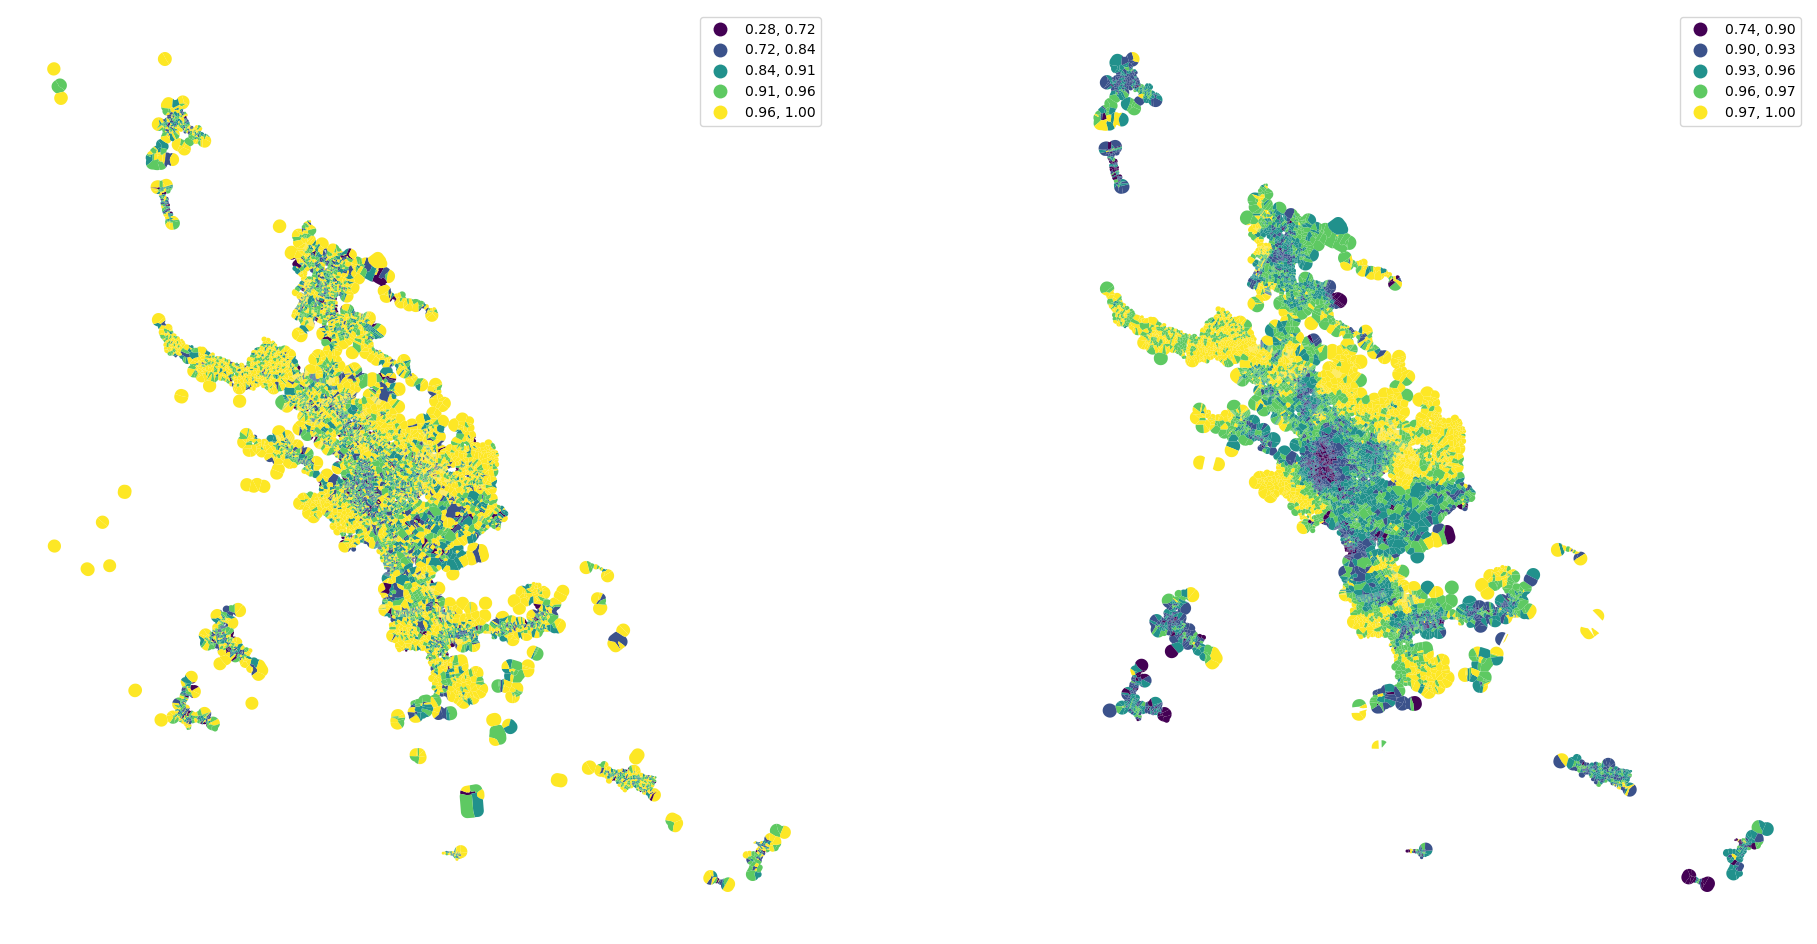

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(
    percentiles_joined["convexity_50"].values,
    ax=ax[1],
    scheme="natural_breaks",
    legend=True,
)

ax[0].set_axis_off()
ax[1].set_axis_off()

## Clustering

In [45]:
standardized = (
    percentiles_joined - percentiles_joined.mean()
) / percentiles_joined.std()
standardized.head()

,tess_area_25,tess_area_50,tess_area_75,convexity_25,convexity_50,convexity_75,neighbors_25,neighbors_50,neighbors_75,covered_area_25,...,y_75,degree_25,degree_50,degree_75,closeness_25,closeness_50,closeness_75,meshedness_25,meshedness_50,meshedness_75
focal,,,,,,,,,,,,,,,,,,,,,
0,-0.230890,-0.327075,0.189469,0.312596,-0.073495,0.179911,-0.830902,-0.130405,-0.035771,-0.287979,...,0.028675,0.544344,0.238197,-0.085788,0.072214,0.327448,0.320322,0.198999,-0.010034,0.116557
1,-0.135072,-0.186586,0.448628,-0.213889,-1.171310,-0.500606,-0.453950,-0.631839,0.061300,0.051031,...,0.021394,-1.662335,0.238197,-0.085788,-1.140930,-0.455627,0.050963,-0.881838,-0.147651,-0.188420
2,-0.324348,-0.488263,-0.616612,0.480464,0.584444,0.174510,0.902995,0.538040,0.124798,-0.310646,...,0.164762,-1.662335,0.238197,-0.085788,0.366966,1.165156,1.648937,-0.179294,0.544249,0.370056
3,-0.231976,-0.414254,-0.549929,-0.157417,0.180288,0.219150,0.320076,0.436781,-0.095393,-0.319159,...,0.163363,-1.662335,0.238197,1.385011,-0.387386,0.731487,0.987833,-0.261946,-0.053563,0.256785
4,-0.328222,-0.463605,-0.609608,0.119540,0.262620,0.021886,1.103918,0.658237,0.083845,-0.336359,...,0.163363,0.544344,0.238197,1.385011,0.366966,1.165156,1.648937,-0.179294,0.544249,0.370705


## How many clusters?

In [46]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=42)
cgram.fit(standardized.fillna(0))

show(cgram.bokeh())

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.289 seconds.
K=3 fitted in 0.403 seconds.
K=4 fitted in 0.337 seconds.
K=5 fitted in 0.226 seconds.
K=6 fitted in 0.317 seconds.
K=7 fitted in 0.298 seconds.
K=8 fitted in 0.398 seconds.
K=9 fitted in 0.419 seconds.
K=10 fitted in 0.492 seconds.
K=11 fitted in 0.530 seconds.


In [47]:
cgram.labels.head()

,1,2,3,4,5,6,7,8,9,10,11
0,0,1,0,3,1,0,4,1,1,5,8
1,0,0,0,3,1,0,4,1,8,5,8
2,0,1,1,1,0,5,0,3,3,2,1
3,0,1,1,1,1,0,4,1,1,2,1
4,0,1,1,1,0,5,0,3,3,2,1


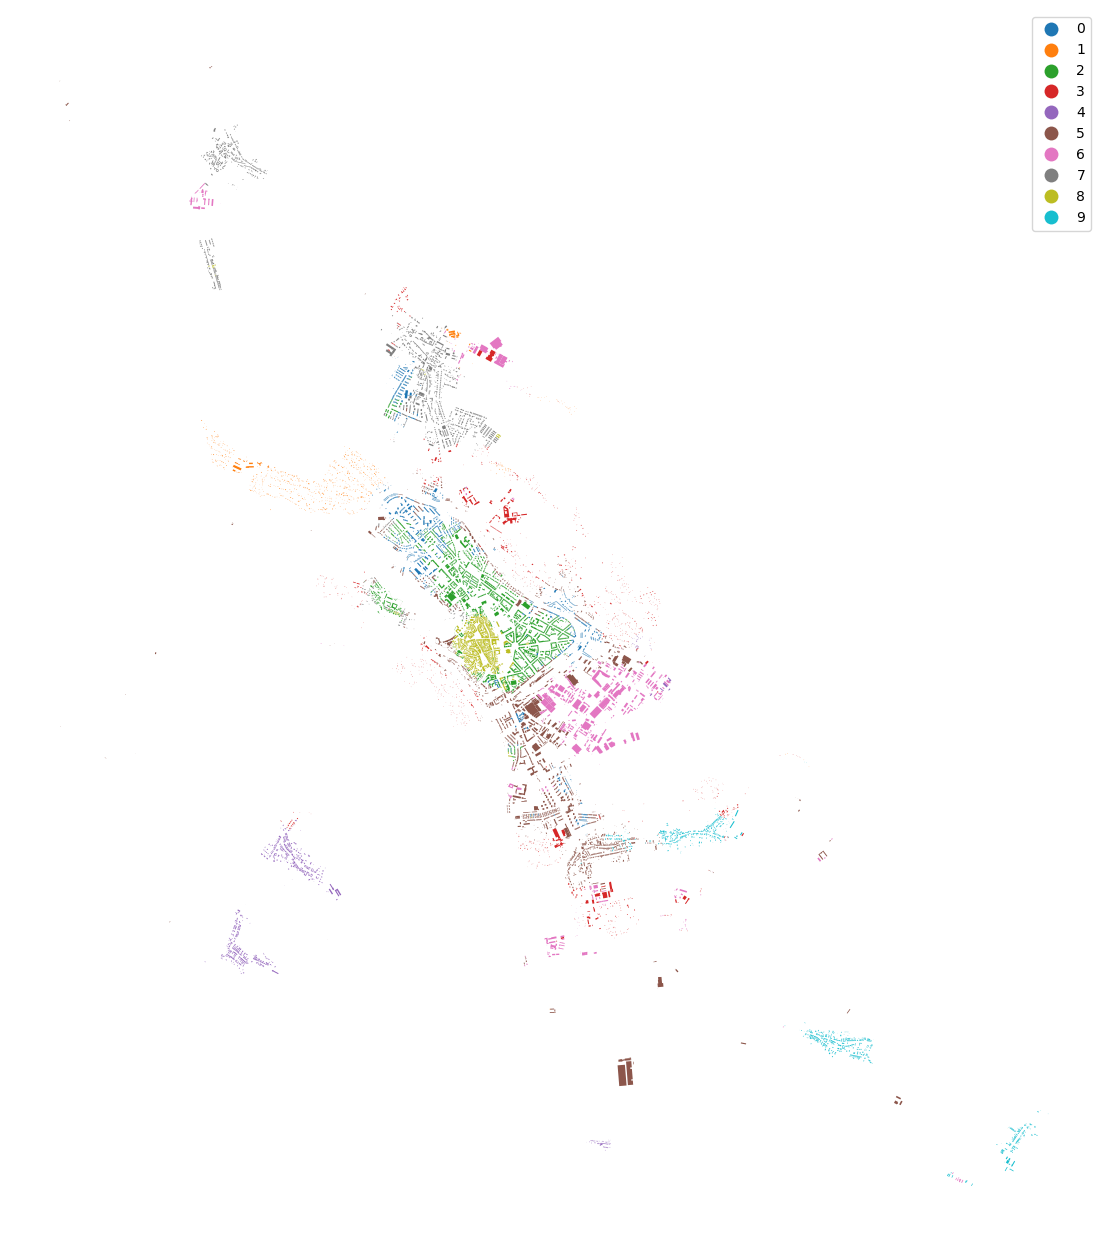

In [48]:
merged["cluster"] = cgram.labels[10].values
buildings["cluster"] = merged["cluster"]
buildings.plot(
    "cluster", categorical=True, figsize=(16, 16), legend=True
).set_axis_off()

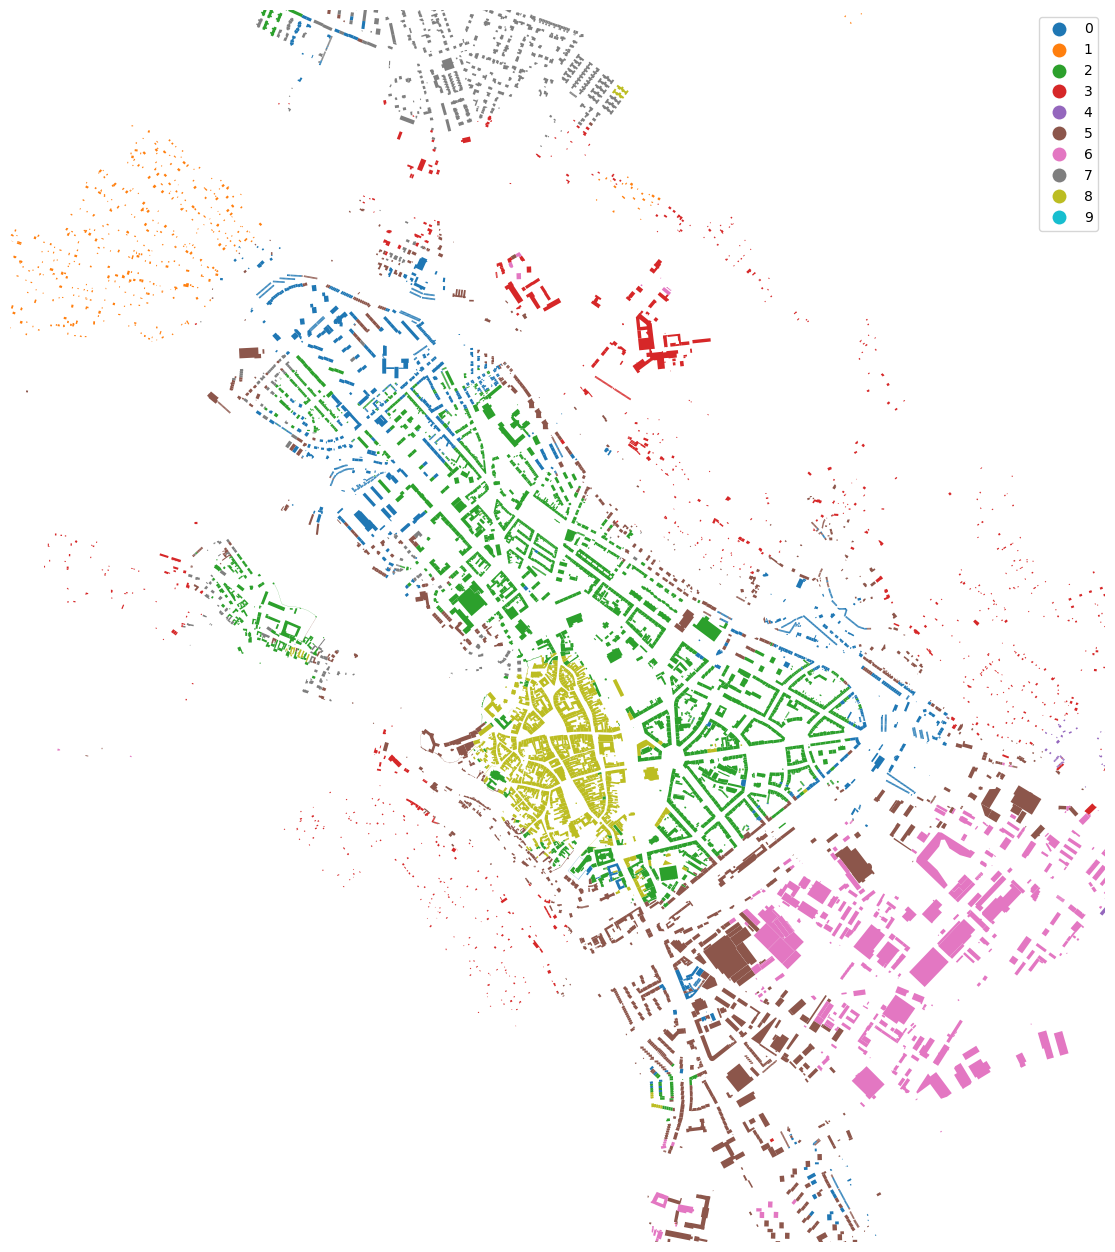

In [49]:
ax = buildings.plot("cluster", categorical=True, figsize=(16, 16), legend=True)
ax.set_xlim(-645000, -641000)
ax.set_ylim(-1195500, -1191000)
ax.set_axis_off()